# Perceptrón Multicapa

Como modelo simple para ir aprendiendo el uso de PyTorch vamos a crear un perceptrón multicapa y entrenarlo con los datos en bruto.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%reload_ext autoreload

import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import repackage
repackage.up()

from utils import *
from fluxdataset import *

In [2]:
PATH = "../datos/"
TRAIN_FILE = "exoTrain.csv"
TEST_FILE = "exoTest.csv"

In [3]:
#leemos los datos de ambos datasets
df_train_raw = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test_raw = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)
train_x, train_y = generate_x_y_df(df_train_raw)
train_y = train_y.add(-1) #pasamos de 1-2 a 0-1

In [4]:
train_x.shape, train_y.shape

((5087, 3197), (5087,))

In [5]:
#definicion del modelo
class Perceptron(torch.nn.Module):
    #definimos la estructura de la red
    #capa de entrada x con activacion relu
    #capa oculta con activacion relu
    #capa de salida con activacion softmax
    def __init__(self, n_features, n_hidden):
        super(Perceptron, self).__init__()
        self.fully_connected_1 = torch.nn.Linear(n_features, n_hidden)
        self.fully_connected_2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fully_connected_3 = torch.nn.Linear(n_hidden, 2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = 1)
        #self.softmax = torch.nn.Sigmoid()
        
    #definimos el flujo 
    def forward(self, x):
        x = self.relu(self.fully_connected_1(x))
        x = self.relu(self.fully_connected_2(x))
        x = self.softmax(self.fully_connected_3(x))
        #x = self.fully_connected_3(x)
        return x

In [6]:
learning_rate = 0.01
epochs = 50
train_x_tensor = torch.tensor(train_x.values).float()
train_y_tensor = torch.tensor(train_y.values)

In [7]:
#instanciamos nuestro modelo
modelo = Perceptron(n_features = train_x.shape[1], n_hidden = 300) 

In [8]:
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [9]:
for epoch in range(epochs):
    #limpiamos los gradientes
    optimizer.zero_grad()
    #propagamos la entrada hacia delante
    predictions = modelo(train_x_tensor)
    #calculamos la perdida
    loss = loss_function(predictions.squeeze(), train_y_tensor)
    #ejecutamos back-propagation
    loss.backward()
    #actualizamos los pesos
    optimizer.step()
    #imprimimos
    if epoch % 10 == 0:
        print('Epoch: {} loss: {}'.format(epoch, loss.item()))
        
print('Epoch: {} loss: {}'.format(epochs, loss.item()))

Epoch: 0 loss: 0.4815114438533783
Epoch: 10 loss: 0.32762759923934937
Epoch: 20 loss: 0.32567983865737915
Epoch: 30 loss: 0.3246314525604248
Epoch: 40 loss: 0.32396364212036133
Epoch: 50 loss: 0.32353726029396057


In [10]:
predictions

tensor([[1.0000e+00, 4.4413e-39],
        [1.0000e+00, 2.0166e-11],
        [1.0000e+00, 0.0000e+00],
        ...,
        [1.0000e+00, 2.3097e-12],
        [9.9948e-01, 5.1692e-04],
        [1.0000e+00, 4.0380e-15]], grad_fn=<SoftmaxBackward>)

Como sospechabamos, sin hacer ningun tratamiento previo a los datos, el modelo solamente devuelve que no existe exoplaneta con certeza absoluta en practicamente todos los casos.

## Preparando los datos

- normalizar
- eliminar picos de luz

In [54]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_test['LABEL'] = df_test['LABEL'].add(-1)

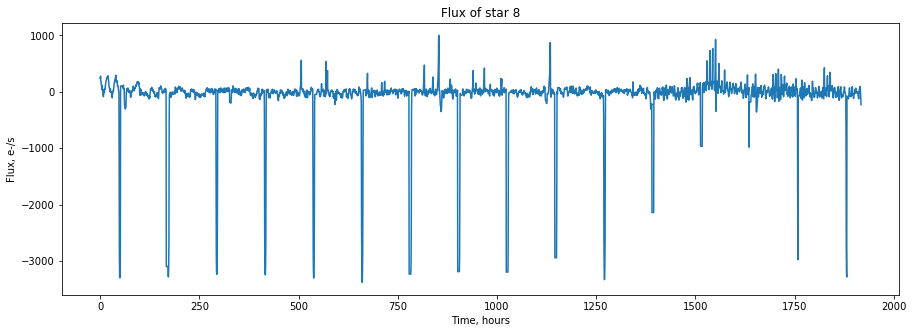

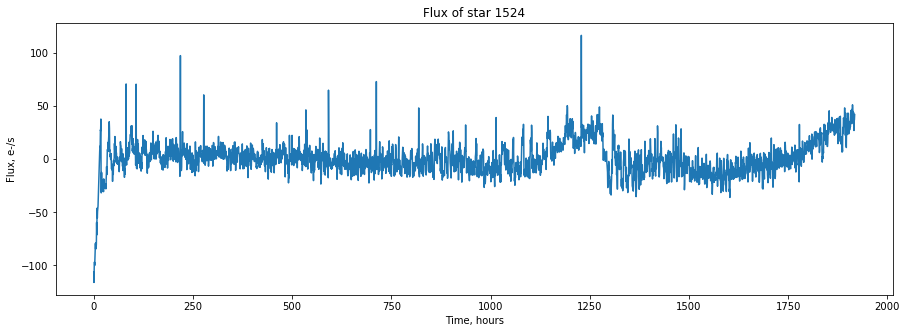

In [55]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [1523])

In [56]:
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])

Veamos como queda tras procesar el dataset

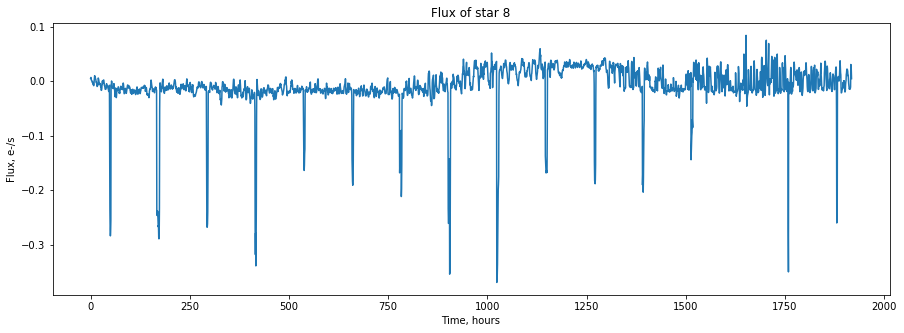

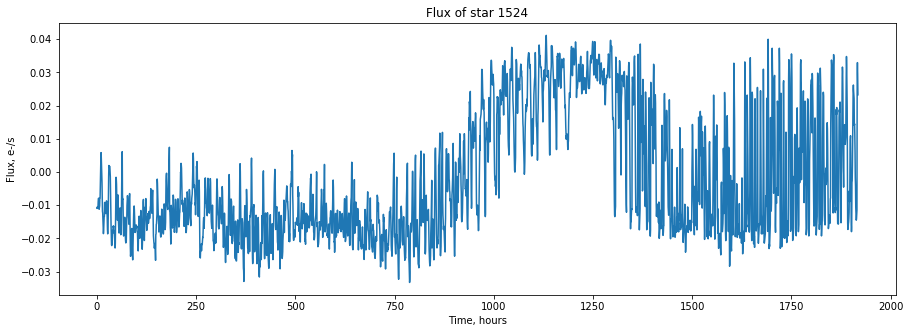

In [57]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [1523])

In [58]:
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)

In [6]:
class Perceptron(torch.nn.Module):
    def __init__(self, output = 2):
        super(Perceptron, self).__init__()
        self.fc1 = torch.nn.Linear(3197, 1000)
        self.fc2 = torch.nn.Linear(1000, 250)
        self.fc3 = torch.nn.Linear(250, 20)
        self.fc4 = torch.nn.Linear(20, output)
        self.relu = torch.nn.ReLU()
        #self.logsoftmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        #x = self.logsoftmax(self.fc4(x))
        x = self.fc4(x)
        return x

In [60]:
epochs = 100
learning_rate = 0.001
alpha = 0.5
beta = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_sgd_cross_01"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[1], max(weights)/weights[0]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)

In [19]:
train_losses, validation_losses, scores = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 0.23231460815630237 Validation loss 0.059378135949373245
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.060136251104881196 Validation loss 0.02181403525173664
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.04667965247655054 Validation loss 0.013692827895283699
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.04388565747685163 Validation loss 0.010533696040511131
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.04302365484113144 Validation loss 0.009061061777174473
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.042738952976481656 Validation loss 0.008217216469347477
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.04263261248658214 Validation loss 0.

Score 0.4965585172176361 at epoch 70
Epoch: 70 Train loss 0.04001984306326849 Validation loss 0.007777537684887648
Score 0.4965585172176361 at epoch 71
Epoch: 71 Train loss 0.03995333825072436 Validation loss 0.007479744032025337
Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 0.03994541450635889 Validation loss 0.00766551960259676
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 0.0398848358058582 Validation loss 0.007553702220320702
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 0.03983632848959608 Validation loss 0.007808612193912268
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 0.039796378673919525 Validation loss 0.007668967824429274
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 0.03975145238210248 Validation loss 0.007857109420001507
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 0.03969090704120243 Validation loss 0.007872208021581173
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 0.03965173582117722 Val

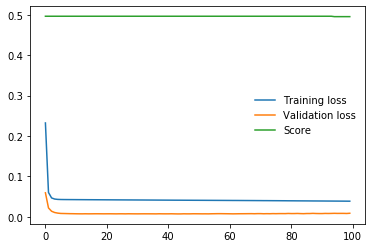

In [20]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

In [21]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_01"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[1], max(weights)/weights[0]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [22]:
train_losses, validation_losses, scores = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 0.1451855551491916 Validation loss 0.011548805981874466
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.2341619431707843 Validation loss 0.008341968059539795
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.05973594482735856 Validation loss 0.0014410085277631879
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.06397184312446623 Validation loss 0.0019238484092056751
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.056480744835581846 Validation loss 0.05568673089146614
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.05805020039856963 Validation loss 0.0010949915740638971
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.05747127968046501 Validation loss 0.

Score 0.4965585172176361 at epoch 70
Epoch: 70 Train loss 0.04088919244761549 Validation loss 0.006627189461141825
Score 0.4965585172176361 at epoch 71
Epoch: 71 Train loss 0.040882185343149545 Validation loss 0.006711735390126705
Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 0.040820161073928565 Validation loss 0.00638743257150054
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 0.04090901686459853 Validation loss 0.006623333320021629
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 0.040882972417358096 Validation loss 0.006780196446925402
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 0.04087614819810197 Validation loss 0.0069087413139641285
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 0.04086734047685853 Validation loss 0.00692121172323823
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 0.04087207832851925 Validation loss 0.006959531456232071
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 0.040864620161876634

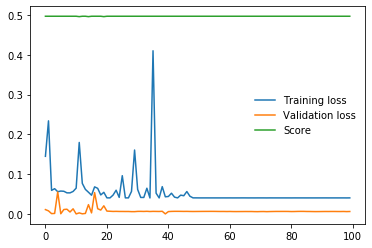

In [23]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

In [63]:
modelo = Perceptron(1).to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_bce_01"
weights = df_train['LABEL'].value_counts()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(max(weights)/weights[1])).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [64]:
train_losses, validation_losses, scores = train_bce(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 10.517479208865975 Validation loss 1.3171192407608032
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 15.46036856492995 Validation loss 4.627295970916748
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 9.287705202631342 Validation loss 1.3243354558944702
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 1.662726437283968 Validation loss 1.3678407669067383
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 2.677154523163521 Validation loss 1.620906949043274
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 1.4859230393273826 Validation loss 1.4186782836914062
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 2.2129446276136346 Validation loss 1.3580520153045654
Score 0.4

Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 1.3560467552933704 Validation loss 1.3297685384750366
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 1.3553314661657487 Validation loss 1.3298393487930298
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 1.3568320200689301 Validation loss 1.3298121690750122
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 1.3565205653850219 Validation loss 1.329877257347107
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 1.3564340361506113 Validation loss 1.3297666311264038
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 1.3563688788865063 Validation loss 1.3297492265701294
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 1.3555531626105015 Validation loss 1.3299084901809692
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 1.355773869515637 Validation loss 1.329970121383667
Score 0.4965585172176361 at epoch 80
Epoch: 80 Train loss 1.356943681667712 Validation loss 1.3299089670181

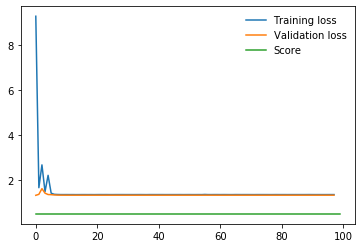

In [65]:
plt.plot(train_losses[2:], label = 'Training loss')
plt.plot(validation_losses[2:], label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

## Reduciendo el dataset

In [76]:
# Creamos un mini dataset balanceado, con todos los casos positivos que tenemos
# y un numero igual de casos negativos
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)

df_train_little = df_train[df_train.LABEL.eq(1)]
df_train_little = df_train_little.append(df_train[df_train.LABEL.eq(0)].sample(n = len(df_train_little)))

df_train_little.iloc[:, 1:] = reduce_upper_outliers(df_train_little.iloc[:, 1:], 0.01)
df_train_little.iloc[:, 1:] = z_score_normalizing(df_train_little.iloc[:, 1:])

df_train_little, df_validation_little = split_train_df(df_train_little, validation_proportion)

In [77]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_02"
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [78]:
train_losses, validation_losses, scores = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train_little, df_validation_little, device)

using device cuda
Score 0.25 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	0		7
Positivos	0		7

Acierto: 0.5 Sensibilidad: 1.0 Especificidad: 0.0 Score: 0.25
Epoch: 0 Train loss 0.738320621351401 Validation loss 0.6455075144767761
Score 0.25 at epoch 1
Epoch: 1 Train loss 0.6791193634271622 Validation loss 0.672632098197937
Score 0.4132653474807739 at epoch 2
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	7		0
Positivos	5		2

Acierto: 0.6428571939468384 Sensibilidad: 0.2857142984867096 Especificidad: 1.0 Score: 0.4132653474807739
Epoch: 2 Train loss 0.7196104149023692 Validation loss 0.8005761504173279
Score 0.4132653474807739 at epoch 3
Epoch: 3 Train loss 0.6216507116953532 Validation loss 0.8467089533805847
Score 0.4132653474807739 at epoch 4
Epoch: 4 Train loss 0.6512368142604827 Validation loss 0.9700278639793396
Score 0.4132653474807739 at epoch 5
Epoch: 5 Train loss 0.548930

Score 0.5102040767669678 at epoch 67
Epoch: 67 Train loss 0.21430767228206 Validation loss 0.919618546962738
Score 0.4132653772830963 at epoch 68
Epoch: 68 Train loss 0.10278843641281128 Validation loss 1.2346785068511963
Score 0.4132653772830963 at epoch 69
Epoch: 69 Train loss 0.07592186927795411 Validation loss 1.4965993165969849
Score 0.5102040767669678 at epoch 70
Epoch: 70 Train loss 0.1770607183376948 Validation loss 1.5310145616531372
Score 0.4132653772830963 at epoch 71
Epoch: 71 Train loss 0.0811175286769867 Validation loss 1.4014095067977905
Score 0.5102040767669678 at epoch 72
Epoch: 72 Train loss 0.08850179314613342 Validation loss 1.6741101741790771
Score 0.5102040767669678 at epoch 73
Epoch: 73 Train loss 0.06454618175824484 Validation loss 1.9812616109848022
Score 0.3265306353569031 at epoch 74
Epoch: 74 Train loss 0.2616110533475876 Validation loss 1.3898980617523193
Score 0.5102040767669678 at epoch 75
Epoch: 75 Train loss 0.07349050690730413 Validation loss 1.7102135

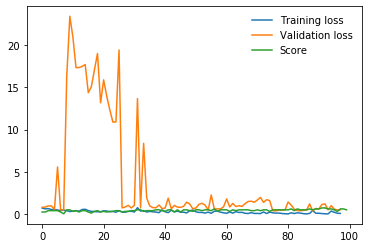

In [79]:
plt.plot(train_losses[2:], label = 'Training loss')
plt.plot(validation_losses[2:], label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

## Suavizando la señal

Probamos a suavizar la señal reduciéndola con un suavizado gaussiano

In [8]:
epochs = 100
learning_rate = 0.001
alpha = 0.5
beta = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_test['LABEL'] = df_test['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], True)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)

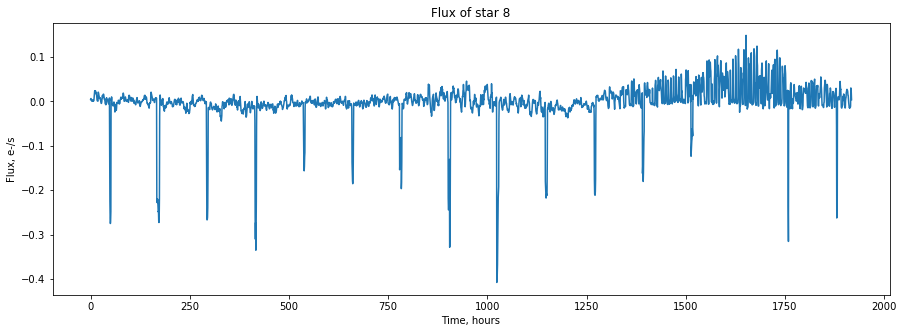

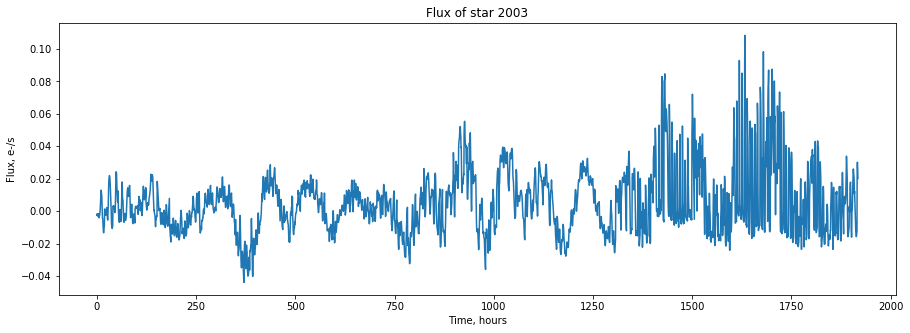

In [4]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [2002])

In [9]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_sgd_cross_03"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)

In [12]:
train_losses, validation_losses, scores = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361

Epoch: 0 Train loss 0.2807297099061329 Validation loss 1.3388917446136475
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.06430612638482884 Validation loss 1.8305871486663818
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.04765824100016376 Validation loss 2.078774929046631
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.04409715300403005 Validation loss 2.20257306098938
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.04292528506286021 Validation loss 2.272944450378418
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.04231856308639489 Validation loss 2.302720785140991
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.04197736202352463 Validation loss 2.318307399749756
Sc

Score 0.7114763855934143 at epoch 66
Epoch: 66 Train loss 0.013511146096105365 Validation loss 0.7972515225410461
Score 0.7102813720703125 at epoch 67
Epoch: 67 Train loss 0.013254825750718246 Validation loss 0.8187445402145386
Score 0.7102813720703125 at epoch 68
Epoch: 68 Train loss 0.013028828532455594 Validation loss 0.7886654734611511
Score 0.7102813720703125 at epoch 69
Epoch: 69 Train loss 0.012740255273530758 Validation loss 0.7481348514556885
Score 0.7102813720703125 at epoch 70
Epoch: 70 Train loss 0.012512341961813793 Validation loss 0.7828218936920166
Score 0.7102813720703125 at epoch 71
Epoch: 71 Train loss 0.012308837469731267 Validation loss 0.7730201482772827
Score 0.7102813720703125 at epoch 72
Epoch: 72 Train loss 0.01207996639411631 Validation loss 0.771399974822998
Score 0.7102813720703125 at epoch 73
Epoch: 73 Train loss 0.011861593021807565 Validation loss 0.7386901378631592
Score 0.780866265296936 at epoch 74
New model saved
Matriz de confusión:
			Predicciones
V

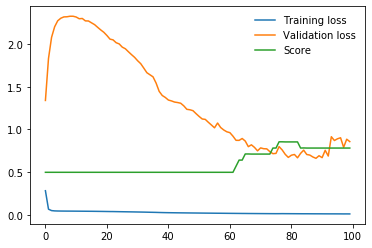

In [13]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

SGD, solo filtro

In [11]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], False)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)

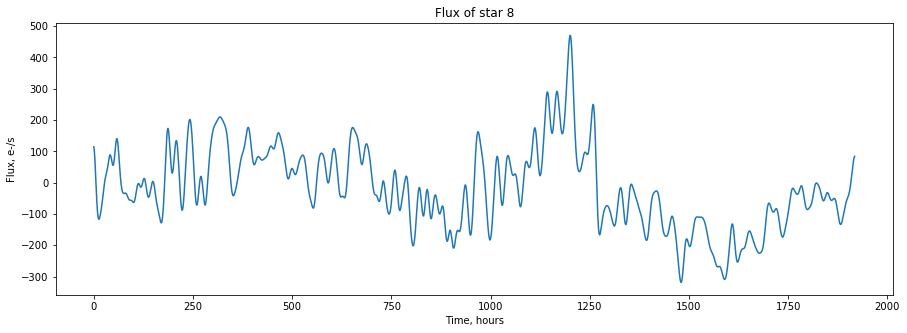

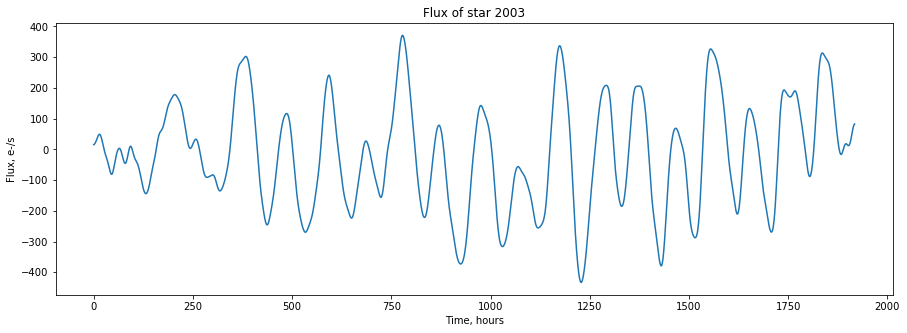

In [29]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [2002])

In [18]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_sgd_cross_04"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)
train_losses, validation_losses, scores = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361

Epoch: 0 Train loss 0.26427487701690167 Validation loss 1.1761983633041382
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.07609643146798417 Validation loss 1.6192482709884644
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.045867381459079155 Validation loss 1.7844980955123901
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.03956727756036294 Validation loss 1.8080518245697021
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.037485696789087766 Validation loss 1.810930848121643
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.03631736435527005 Validation loss 1.757269024848938
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.03549279115123889 Validation loss 1.713891625404

Score 1.0 at epoch 62
Epoch: 62 Train loss 0.000949805887090625 Validation loss 0.007128690369427204
Score 1.0 at epoch 63
Epoch: 63 Train loss 0.0009396565185640234 Validation loss 0.006187691353261471
Score 1.0 at epoch 64
Epoch: 64 Train loss 0.0008742715348771146 Validation loss 0.00555591331794858
Score 1.0 at epoch 65
Epoch: 65 Train loss 0.0008288210820800256 Validation loss 0.005058536771684885
Score 1.0 at epoch 66
Epoch: 66 Train loss 0.0007688550008529527 Validation loss 0.0054260678589344025
Score 1.0 at epoch 67
Epoch: 67 Train loss 0.0007716896126838516 Validation loss 0.004914965480566025
Score 1.0 at epoch 68
Epoch: 68 Train loss 0.000718036887100932 Validation loss 0.004272333346307278
Score 1.0 at epoch 69
Epoch: 69 Train loss 0.0006922763522888285 Validation loss 0.004437664058059454
Score 1.0 at epoch 70
Epoch: 70 Train loss 0.000657651611747957 Validation loss 0.0038656294345855713
Score 1.0 at epoch 71
Epoch: 71 Train loss 0.0006426376997692286 Validation loss 0.0

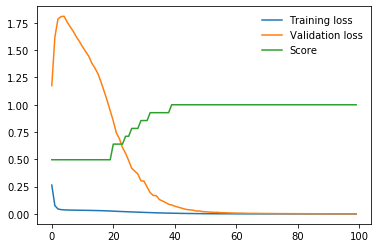

In [19]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

Adam, con diferencia

In [20]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], True)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_03"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)
train_losses, validation_losses, scores = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361

Epoch: 0 Train loss 0.5953767037948168 Validation loss 1.890683650970459
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.12479115339403363 Validation loss 1.6107572317123413
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.04929997083303091 Validation loss 1.9339652061462402
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.05572364313084019 Validation loss 1.94455885887146
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.04376684494627781 Validation loss 1.750825047492981
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.03545293805054423 Validation loss 2.5054728984832764
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.02617027961651289 Validation loss 1.573851466178894
S

Score 0.7720404267311096 at epoch 65
Epoch: 65 Train loss 0.005918893781868187 Validation loss 20.222728729248047
Score 0.7720404267311096 at epoch 66
Epoch: 66 Train loss 0.005898162803134403 Validation loss 20.237808227539062
Score 0.7720404267311096 at epoch 67
Epoch: 67 Train loss 0.005922260258063051 Validation loss 20.26142692565918
Score 0.7720404267311096 at epoch 68
Epoch: 68 Train loss 0.005923130661615283 Validation loss 20.2840518951416
Score 0.7720404267311096 at epoch 69
Epoch: 69 Train loss 0.005902194947516889 Validation loss 20.303556442260742
Score 0.7720404267311096 at epoch 70
Epoch: 70 Train loss 0.005907189143084777 Validation loss 20.32402992248535
Score 0.7720404267311096 at epoch 71
Epoch: 71 Train loss 0.005912485286703273 Validation loss 20.34159278869629
Score 0.7720404267311096 at epoch 72
Epoch: 72 Train loss 0.005910907535646706 Validation loss 20.36289405822754
Score 0.7720404267311096 at epoch 73
Epoch: 73 Train loss 0.00590765304881759 Validation loss 

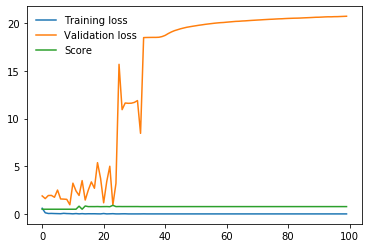

In [21]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

ADAM, solo filtro

In [22]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], False)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_04"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)
train_losses, validation_losses, scores = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.7090874314308167 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1008		2
Positivos	4		3

Acierto: 0.9941003322601318 Sensibilidad: 0.4285714328289032 Especificidad: 0.998019814491272 Score: 0.7090874314308167

Epoch: 0 Train loss 0.8413982365728889 Validation loss 7.665062427520752
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.45294739046026505 Validation loss 14.035597801208496
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.08122058952323342 Validation loss 3.7462680339813232
Score 0.8541208505630493 at epoch 3
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1009		1
Positivos	2		5

Acierto: 0.9970501661300659 Sensibilidad: 0.7142857313156128 Especificidad: 0.999009907245636 Score: 0.8541208505630493

Epoch: 3 Train loss 0.22709585603427243 Validation loss 5.234044551849365
Score 0.8541208505630493 at epoch 4
Epoch: 4 Train loss 0.19332

Score 0.8487849831581116 at epoch 62
Epoch: 62 Train loss 6.090510975230824e-07 Validation loss 94.22242736816406
Score 0.8487849831581116 at epoch 63
Epoch: 63 Train loss 4.002151694589269e-07 Validation loss 95.26839447021484
Score 0.8487849831581116 at epoch 64
Epoch: 64 Train loss 2.6735685381315263e-07 Validation loss 96.3270034790039
Score 0.8487849831581116 at epoch 65
Epoch: 65 Train loss 1.803077116645232e-07 Validation loss 97.26701354980469
Score 0.8487849831581116 at epoch 66
Epoch: 66 Train loss 1.2079093569740356e-07 Validation loss 98.54743957519531
Score 0.8487849831581116 at epoch 67
Epoch: 67 Train loss 8.18941458437308e-08 Validation loss 99.68770599365234
Score 0.8487849831581116 at epoch 68
Epoch: 68 Train loss 5.412746142489888e-08 Validation loss 100.67188262939453
Score 0.8487849831581116 at epoch 69
Epoch: 69 Train loss 3.6670769168938114e-08 Validation loss 101.62763977050781
Score 0.8487849831581116 at epoch 70
Epoch: 70 Train loss 2.472055046212761e-08 Valid

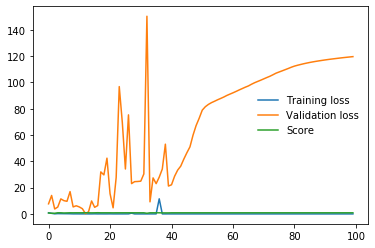

In [23]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

Cross, bce, con diferencia

In [35]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], True)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron(1).to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_bce_02"
weights = df_train['LABEL'].value_counts()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(max(weights)/weights[1])).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [36]:
train_losses, validation_losses, scores = train_bce(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361

Epoch: 0 Train loss 8.41983179734878 Validation loss 548.3500366210938
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 2.6546194153081966 Validation loss 523.2275390625
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.9247927939411184 Validation loss 251.70223999023438
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 1.5754437985922183 Validation loss 0.8836212754249573
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 1.4074939191920903 Validation loss 0.8585384488105774
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.7018222198270571 Validation loss 1.2730388641357422
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 1.0714731159645756 Validation loss 1.5337867736816406
Score 0.4

Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 1.3793716983801023 Validation loss 1.3297913074493408
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 1.3797141033103484 Validation loss 1.3298416137695312
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 1.3790034683096322 Validation loss 1.329763412475586
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 1.3795805610661425 Validation loss 1.329781413078308
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 1.3793872410600836 Validation loss 1.3298051357269287
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 1.3790230502514054 Validation loss 1.3297713994979858
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 1.380145447699385 Validation loss 1.3298131227493286
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 1.3792780595710294 Validation loss 1.329833745956421
Score 0.4965585172176361 at epoch 80
Epoch: 80 Train loss 1.37938652359297 Validation loss 1.329792499542236

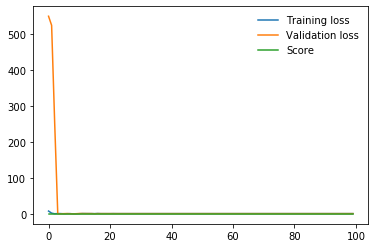

In [37]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

Cross, bce, solo filtro

In [38]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], False)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron(1).to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_bce_03"
weights = df_train['LABEL'].value_counts()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(max(weights)/weights[1])).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [39]:
train_losses, validation_losses, scores = train_bce(modelo, model_name, criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation, device)

using device cuda
Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361

Epoch: 0 Train loss 5.891431685275323 Validation loss 1.2975133657455444
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 2.0700115000060064 Validation loss 0.0020529022440314293
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 1.1518455966368215 Validation loss 0.01798553206026554
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 1.3612335426308684 Validation loss 0.7938594222068787
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 1.2316436162674602 Validation loss 1.3299137353897095
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 1.3840577163186647 Validation loss 1.3298743963241577
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 1.3808180333501876 Validation loss 1.3297302722930908

Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 1.379525656503893 Validation loss 1.3297638893127441
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 1.3801513265040348 Validation loss 1.3297233581542969
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 1.3805345125661141 Validation loss 1.3298014402389526
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 1.3796653405454293 Validation loss 1.3298841714859009
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 1.380436362022264 Validation loss 1.3298436403274536
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 1.3794828173569438 Validation loss 1.3298171758651733
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 1.3791651000115444 Validation loss 1.329802393913269
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 1.3781974694213353 Validation loss 1.329726219177246
Score 0.4965585172176361 at epoch 80
Epoch: 80 Train loss 1.3800318932503974 Validation loss 1.3297401666641

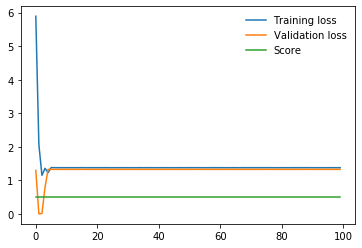

In [40]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)